# Synthetic case : Study of the fit to a exponential autocorrelation function

## First part : 
For a fixed decorrelation timescale, we discuss the accuracy of the results depending on the use of detrending or not, and of normalized correlation or not.
## Second part : 
For a fixed decorrelation timescale, we vary the time window size and the number of segments used.
## Third part : 
Same study than the second part but for three decorrelation timescales (5, 10 and 20 days)

In [1]:
import numpy as np
import xarray as xr
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import sstats.tseries as ts
from inspect import signature

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:59205 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


### Exponential correlation :
$R_{xx} \propto e^{-\tau/T_L}$

In [3]:
# Model we want to fit to our data :  
def C_exp(t,Tb,a):
    return a*np.exp(-t/Tb)

### Generation of the dataset : 
Data are generated using the sstats library. The dataset has 3 dimensions. First, the time limited by the time window size, Tw, second Nw, the number of time segments over which we will compute the autocorrelation and finally, the number of draws used to obtain results robust enough. \
We define also a decorrelation timescale, Tl which is the value we want to find thanks to the fit.

In [4]:
Tw = 500
Nw = 30
Tl = 10
x = ts.exp_autocorr((Tw, 1./24), np.full((Nw,),Tl), 1, draws=100).rename('x').rename({'tau':'windows'}).compute()
x

<xarray.DataArray 'x' (windows: 30, draw: 100, time: 12000)>
array([[[-1.88785874e-02, -9.37090640e-02, -1.18951900e-01, ...,
          2.64595315e-01,  1.57020977e-01,  7.67812141e-02],
        [ 6.27661027e-02, -1.91952752e-02, -8.89812264e-03, ...,
          2.56243197e-01,  2.07894231e-01,  2.00767796e-01],
        [-5.35530986e-02, -1.52769076e-01, -1.55312752e-01, ...,
         -7.83117650e-01, -8.40053456e-01, -9.16587392e-01],
        ...,
        [ 2.26931150e-02,  9.84406750e-02,  3.40899666e-02, ...,
          3.48320634e-01,  2.61766147e-01,  4.60652310e-01],
        [ 4.49213864e-02,  1.31390318e-01,  1.41690152e-01, ...,
         -6.17871510e-01, -6.90485905e-01, -6.66749849e-01],
        [ 1.16944928e-01,  1.11790689e-01,  1.25284017e-01, ...,
         -2.68727605e-01, -2.98806125e-01, -2.91403821e-01]],

       [[ 6.63862091e-03,  4.86919627e-02,  1.34537284e-01, ...,
         -9.63166212e-01, -8.84400074e-01, -9.01801091e-01],
        [ 5.05182649e-02,  4.65505227e-02, -9.79160610e-02, ...,
          1.13664317e+00,  9.57471315e-01,  9.83020718e-01],
        [-5.64097638e-02, -1.19566864e-01, -1.63866404e-01, ...,
          6.52188822e-01,  5.40880000e-01,  4.95949152e-01],
        ...,
        [-3.41660827e-02, -5.56247149e-02, -1.43819966e-01, ...,
          1.70870830e+00,  1.64956108e+00,  1.65829278e+00],
        [-2.93651824e-02,  1.03680986e-01,  4.16198318e-04, ...,
          2.67938032e+00,  2.62267869e+00,  2.51823033e+00],
        [-8.88642304e-02,  6.90862085e-02,  2.42521910e-02, ...,
          1.35978107e+00,  1.30898125e+00,  1.41208595e+00]],

       [[ 1.21986598e-01,  1.64067393e-01,  1.78307998e-02, ...,
          2.04983231e-01,  2.47530103e-01,  1.96341343e-01],
        [-1.66817103e-01, -1.73161621e-01, -1.09812863e-02, ...,
          6.76636454e-01,  6.98620467e-01,  7.02822894e-01],
        [ 7.39675570e-02,  1.43661199e-01,  2.21770024e-01, ...,
          1.64282336e+00,  1.73936411e+00,  1.63467188e+00],
        ...,
        [ 5.25950421e-02,  1.33397911e-01,  1.17445388e-01, ...,
          5.84765105e-01,  6.89910882e-01,  8.48678131e-01],
        [ 6.48211380e-02,  1.01704760e-01, -1.02131834e-01, ...,
         -1.15583478e-01, -6.79159485e-02, -1.68142733e-01],
        [ 2.03886572e-02, -1.50968871e-02, -2.32759240e-02, ...,
         -2.79493053e-01, -2.71202118e-01, -4.52007147e-01]],

       ...,

       [[ 6.21712367e-02,  1.11395302e-01,  2.18082862e-01, ...,
         -4.22728248e-01, -4.52729454e-01, -4.35299813e-01],
        [ 1.46978625e-01,  1.59453231e-01,  1.48052357e-01, ...,
         -6.81671804e-01, -7.17637940e-01, -5.78875772e-01],
        [ 7.54348375e-02,  1.64236778e-01,  2.07965636e-01, ...,
          3.50165482e-02,  2.90072167e-02,  3.97453222e-02],
        ...,
        [ 3.32360936e-03, -7.12310045e-02,  6.83319493e-02, ...,
          1.23703202e+00,  1.16194693e+00,  1.16075383e+00],
        [-3.97797826e-02, -2.16199184e-02, -1.14319350e-01, ...,
         -5.34579764e-01, -3.51491177e-01, -3.36393959e-01],
        [ 1.76056704e-01,  2.35602983e-01,  1.49137191e-01, ...,
         -1.04792046e+00, -1.01620862e+00, -1.17140446e+00]],

       [[-8.00141333e-02, -8.54615161e-02, -1.52198590e-01, ...,
         -6.20937181e-01, -6.72451485e-01, -6.25527984e-01],
        [-5.55244203e-02, -2.22150307e-01, -1.92488789e-01, ...,
          1.51144570e+00,  1.53680395e+00,  1.41814733e+00],
        [ 1.09475923e-01,  3.65595488e-02, -1.22560448e-02, ...,
          1.60727137e+00,  1.45168187e+00,  1.47000426e+00],
        ...,
        [ 9.55078261e-02,  1.73321426e-01,  1.96974285e-01, ...,
         -7.71349026e-01, -7.12690278e-01, -7.60921136e-01],
        [ 8.00669406e-02, -1.79376597e-02, -2.20114421e-01, ...,
         -8.77263026e-03, -3.19848245e-02, -5.47517624e-02],
        [ 6.97379766e-02,  1.84921104e-01,  9.85328022e-02, ...,
          8.14361556e-01,  7.70486165e-01,  7.27791965e-01]],

       [[ 8.48482382e-02,  8.02175881e-02,  1.09510112e-01, ...,
      

### With or without detrending:
We compare the results for detrended and non detrended data.\
We plot in the following cell the autocorrelation functions for each segments for one draw (1st line), the average over all draws for each segments (secand line) and the average over all draws and segments as well as the best fit found (last line).

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


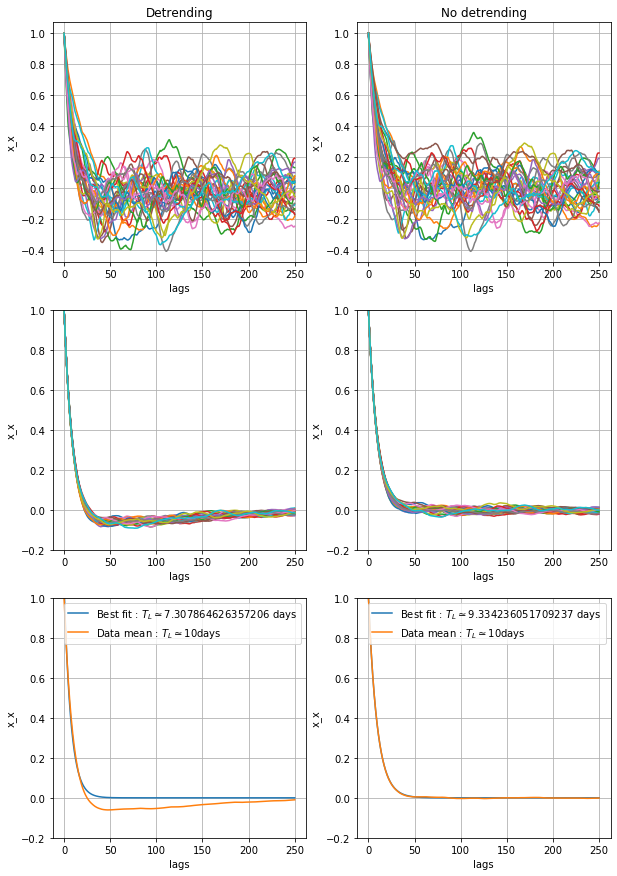

In [4]:
fig, axes = plt.subplots(3,2,figsize=(10,15))
for b,title,i in zip([True, False],['Detrending','No detrending'],range(2)):
    xx = ts.correlate(x,x,detrend=b).compute()
    _ = (xx/xx.sel(lags=0)).isel(draw=10).plot.line(ax=axes[0,i],x='lags',label='')
    axes[0,i].set_title(title);axes[0,i].legend().set_visible(False);axes[0,i].grid()
    _ = (xx/xx.sel(lags=0)).mean('draw').plot.line(ax=axes[1,i],x='lags',label='')
    axes[1,i].legend().set_visible(False);axes[1,i].set_ylim(-0.2,1);axes[1,i].grid()
    pa,co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).mean(['draw','windows']))
    C_exp(xx.lags,*[p for p in pa]).plot(ax=axes[2,i],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    (xx/xx.sel(lags=0)).mean(['draw','windows']).plot(ax=axes[2,i],label='Data mean : $T_L\simeq$10days')
    axes[2,i].legend();axes[2,i].set_ylim(-0.2,1);axes[2,i].grid()
    

#### Comments : 
First line, All windows for one draw : We see the raw data prensent a strong variability (around the threshold, the values can go from -0.4 to 0.4 in the some windows).\
Second line (mean over draws for each window) : We see a negative lobe in the detrended case that is not observed in the second case. We can already expect a less acurate fit in the detrended case.\
Third line : Looking at the mean autocorrelation (over all draws and windows), we find a value very close of the true value, 10 days, with a relatiove error very small in the non detrended case.\ In the case where the signal was deternded, the estimation is not as accurate with a value of the decorrelation timescale around 7 days. This  is due to the negative loe created by the detrending. As it has been seen in our 'real' case, we expect this negative lobe to decrease when the total time window (DT) increases.Still it seems more accurate to use the non detrended time series.



#### Without normalization : 
The same figure than the previous one is plotted here but for non normalized autocorrelation.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


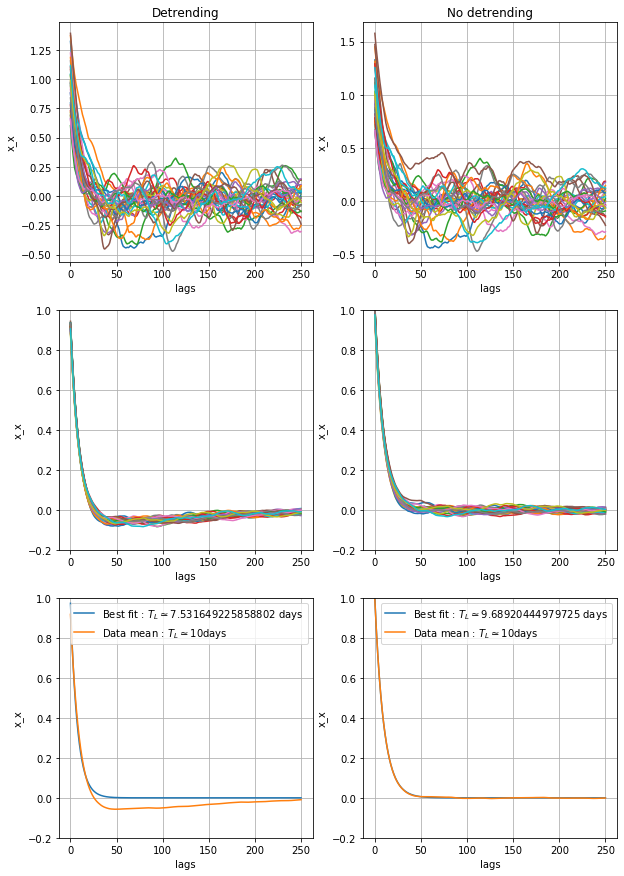

In [5]:
fig, axes = plt.subplots(3,2,figsize=(10,15))
for b,title,i in zip([True, False],['Detrending','No detrending'],range(2)):
    xx = ts.correlate(x,x,detrend=b).compute()
    _ = xx.isel(draw=10).plot.line(ax=axes[0,i],x='lags',label='')
    axes[0,i].set_title(title);axes[0,i].legend().set_visible(False);axes[0,i].grid()
    _ = xx.mean('draw').plot.line(ax=axes[1,i],x='lags',label='')
    axes[1,i].legend().set_visible(False);axes[1,i].set_ylim(-0.2,1);axes[1,i].grid()
    pa,co = scipy.optimize.curve_fit(C_exp,xx.lags,xx.mean(['draw','windows']))
    C_exp(xx.lags,*[p for p in pa]).plot(ax=axes[2,i],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    xx.mean(['draw','windows']).plot(ax=axes[2,i],label='Data mean : $T_L\simeq$10days')
    axes[2,i].legend();axes[2,i].set_ylim(-0.2,1);axes[2,i].grid()

#### Comments : 
Visually, no differences with the normalized case seem to be worthy of notice except the fact that the fit seems to be more accurate for both detrended and non detrended cases (for the mean).

### Conclusions detrending : 
Looking at the results, the detrending of our data causes a negative lobe to appear which jeopardize of the estimation of the decorrelation timescale. For all following parts, we wont look at detrended data anymore.\
As for the normalization, we will continue to compare both normalized and non normalized cases as the differences between the 2 options are not as large as the ones for the detrended ond non detrended cases.

### Fit the mean over all segments for each draw :
For each draw we average the auotcorrelation function over all segments.

In [7]:
#xx = ts.correlate(x,x,detrend=False).compute()
sig = signature(C_exp)
pa,err = np.full((xx.draw.size,len(sig.parameters)-1),np.nan),np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
for i in range(xx.draw.size):
    pa[i,:],co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['windows']))
    err[i,:] = np.abs(pa[i,:]-Tl)/Tl


Averaged over all draws and windows of the estimated $T_L$ : 9.400969970976439
Std of the estimated $T_L$ : 0.8150227927573092
Mean relative error : 8.332970107795655 percent


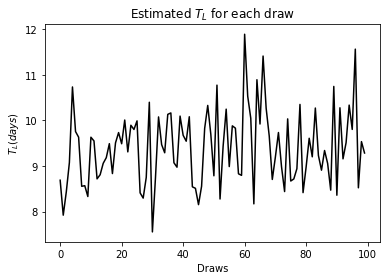

In [8]:
plt.plot(xx.draw,pa[:,0],'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa[:,0].mean())
print(r'Std of the estimated $T_L$ : %s' %pa[:,0].std())
print('Mean relative error : %s percent'% (err[:,0].mean()*1e2))

#### Comments :
We find a mean estimate of TL close to 10 days, with a neagtive bias.

In [9]:
# Same but without normalization of the autocorrelation : 
pa,err = np.full((xx.draw.size,len(sig.parameters)-1),np.nan),np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
for i in range(xx.draw.size):
    pa[i,:],co = scipy.optimize.curve_fit(C_exp,xx.lags,xx.isel(draw=i).mean(['windows']))
    err[i,:] = np.abs(pa[i,:]-Tl)/Tl


Averaged over all draws and windows of the estimated $T_L$ : 9.76312568547402
Std of the estimated $T_L$ : 0.941028035454587
Mean relative error : 7.948538301819368 percent


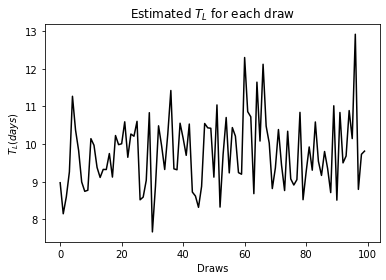

In [10]:
plt.plot(xx.draw,pa[:,0],'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa[:,0].mean())
print(r'Std of the estimated $T_L$ : %s' %pa[:,0].std())
print('Mean relative error : %s percent'% (err[:,0].mean()*1e2))

#### comments :
We find a better mean estimation, the negative bias seems to be be decreased.

### Varying the time window size (DT) and the number of windows (nT) : 
We want to study the sensibilty of our fit to the time series we use and the number of segments. Lets keep in mind that in our 'real' case of study, the more we have time segments, the less our time window is large since we have limited time window size of 500days.

In [4]:
def param_fit(x,myfunc,Tw,Nw,n,X = 'normalized',detrend=False):
    """Compute the autocorrelation function of a dataset x with time window size, Tw and number of segments, Nw 
    and find the best fit using the function myfunc. The parameters are computed fitting the data using myfunc 
    to the average over all segments for each draws.
    Parameters
    ----------
        x : DataArray
            Dataset to use to compute the autocorrleation
        myfunc: func
                Function used for the fit
        Tw: int
            Time window size
        Nw: int
            Number of segments
        n : int
            Number of draws
        X : str
            If X='Normalized', the fit will be made on normalized autocorrelation function
        name: str, optional
    
    Returns
    ----------
    out : Dataset
          Dataset containing the parameters fitted using myfunc for all draws.
    """
    sig = signature(myfunc)
    xx = ts.correlate(x.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,n)),
                      x.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,n)),detrend=detrend).persist()
    if X=='normalized':
        xx = xx/xx.sel(lags=0) 
    else :
        pass
    pa = np.full((xx.draw.size,len(sig.parameters)-1),np.nan)#,np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
    #true_val=[Tl]
    for i in range(xx.draw.size):
        pa[i,:],co = scipy.optimize.curve_fit(myfunc,xx.lags,xx.isel(draw=i).mean(['windows']))
    #    err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = xr.Dataset({'params':(['draws','param'],pa)},
                     coords={"draws":np.arange(0,n,1),'param':[V for V in sig.parameters.keys()][1:]})
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [12]:
Tw = np.arange(20,350,50)#[40,80,100,200]
Nw = np.arange(1,30,5)#[2,5,10,20,30]
out = xr.combine_nested([[param_fit(x,C_exp,T,nt,Tl,100)for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out['Nw'] = nT
out['Tw'] = DT

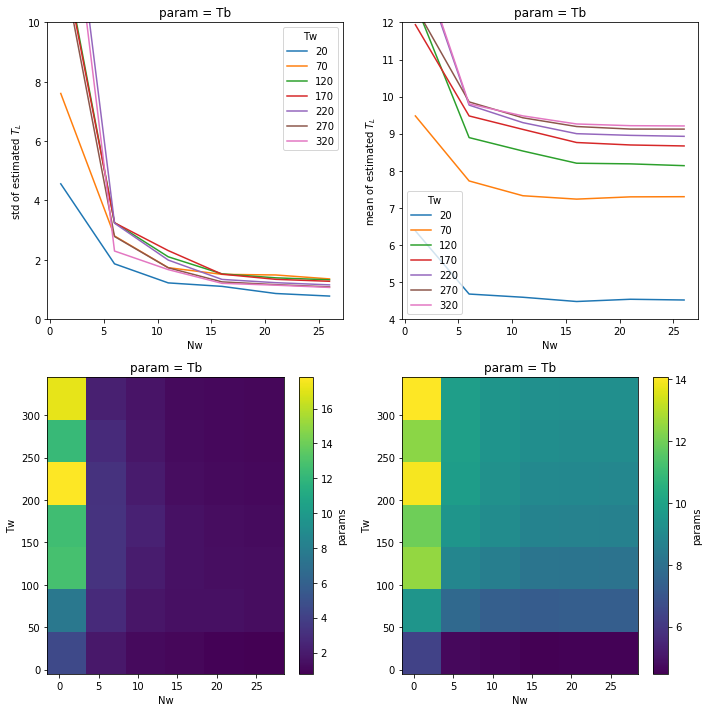

In [13]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
out['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
fig.tight_layout()

#### Comments : 
General comment :  For small values of Nw (2 and 7) the values of the std and mean seem very noisy. 

Std of the estmated decorrelation timescale (first colmun) : For larger numbers the std seems to reach a threshold (Nw$\geq12$). We don't observe large differences in the std depending on Tw, all thresholds seeming to remain between 1 and 2 with the exception of Tw=20days for which the std is smaller and closer to 1.

Mean of the estmated decorrelation timescale (Second column) : As expected, the larger the window size is, the better the estimation seems to be. For each time window size, the mean does not vary a lot for number of segments superior to $\sim$12. The mean seem to stabilize around values superior to 9 days for T$\geq$170days

#### No normalization

In [14]:
Tw = np.arange(20,350,50)#[40,80,100,200]
Nw = np.arange(1,30,5)#[2,5,10,20,30]
out_nonorm= xr.combine_nested([[param_fit(x,C_exp,T,nt,Tl,100,X='')for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out_nonorm['Nw'] = nT
out_nonorm['Tw'] = DT

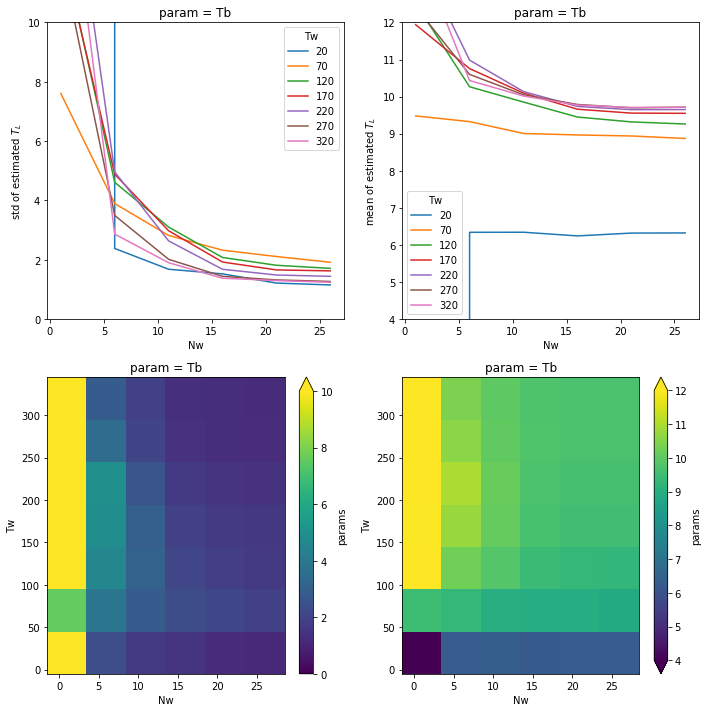

In [16]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out_nonorm['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');
axes[0,0].set_ylabel(r'std of estimated $T_L$')
out_nonorm['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');
axes[0,1].set_ylabel(r'mean of estimated $T_L$')
out_nonorm['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0],vmin=0,vmax=10)
out_nonorm['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1],vmin=4,vmax=12)
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
fig.tight_layout()

### Comments : 
For both normalized and non normalized autocorrelation, the mean value of the estimated decorrelation timescale is far from the true value (10 days) for small values of Tw and Nw.\
In the non normalized case the std is larger for all time windows size and number and we find more differences from a window size to another (threshold decreasing for Tw from 70 to 320days). Tw=20days has also smaller std than the other window sizes but a mean estimation around 6.5days.

The mean estimated Tl closer from one another for all Tw other than 20 days. We find $T_L^*\geq$9 days for Tw$\geq$120days

### Fit for each windows :
We want to study the results of a fit done for each time segments and draw (fit over less smooth data than for the previous cases).


In [45]:
def param_fit2(x,myfunc,Tw,Nw,Tl,n,X = 'normalized',detrend=False):
    """Generate n samples using ts.exp_autocorr 
    and find the best fit for each sample and the relative error to the true value Tl 
    """
    sig = signature(myfunc)
    xx = ts.correlate(x.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,n)),
                      x.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,n)),detrend=detrend).persist()
    if X=='normalized':
        xx = xx/xx.sel(lags=0) 
    else :
        pass
    pa = np.full((xx.draw.size,xx.windows.size,len(sig.parameters)-1),np.nan)
    err = np.full((xx.draw.size,xx.windows.size,len(sig.parameters)-1),np.nan)
    true_val=[Tl]
    for i in range(xx.draw.size):
        for j in range(xx.windows.size):
            try:
                pa[i,j,:],co = scipy.optimize.curve_fit(myfunc,xx.lags,xx.isel(draw=i,windows=j))
                err[i,j,:] = np.abs(pa[i,j,:]-true_val)/true_val
            except:
                pass
            
    
    out = xr.Dataset({'params':(['draw','param'],pa.mean(axis=1)),
                      'errors':(['draw','param'],err.mean(axis=1))},
                     coords={"draws":np.arange(0,n,1),'param':[V for V in sig.parameters.keys()][1:]})
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [31]:
scipy.optimize.curve_fit(C_exp,xx.lags,xx.isel(draw=1,windows=10))

(array([5.81848286, 0.61845069]),
 array([[ 1.39997872e-02, -7.38820444e-04],
        [-7.38820444e-04,  7.85430740e-05]]))

In [46]:
 out2 = xr.combine_nested([[param_fit2(x,C_exp,T,nt,Tl,100)for T in [10,20]] for nt in [2,5]],concat_dim=['Nw','Tw'])

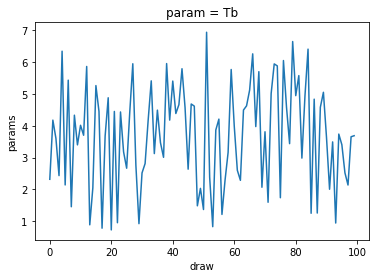

In [52]:
out2['params'].sel(param='Tb').isel(Tw=0,Nw=0).plot()

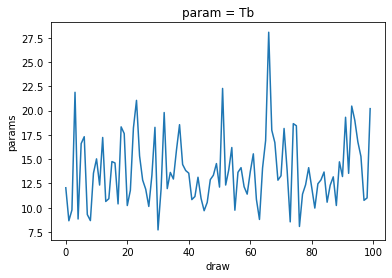

In [23]:
out2['params'].mean('windows').sel(param='Tb').plot()

In [ ]:
out2= xr.combine_nested([[param_fit2(x,C_exp,T,nt,Tl,100)for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out2['Nw'] = Nw
out2['Tw'] = Tw

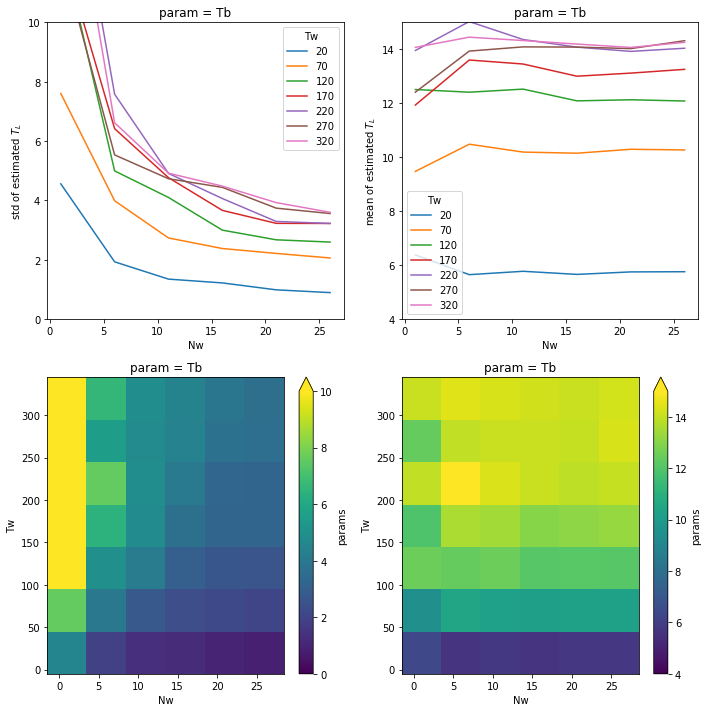

In [62]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out2['params'].sel(param='Tb').std('draw').plot.line(ax=axes[0,0],x='Nw',hue='Tw');
axes[0,0].set_ylabel(r'std of estimated $T_L$')
out2['params'].sel(param='Tb').mean('draw').plot.line(ax=axes[0,1],x='Nw',hue='Tw');
axes[0,1].set_ylabel(r'mean of estimated $T_L$')
out2['params'].sel(param='Tb').std('draw').plot(ax=axes[1,0],vmin=0,vmax=10)
out2['params'].sel(param='Tb').mean('draw').plot(ax=axes[1,1],vmin=4,vmax=15)
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,15)
fig.tight_layout()

#### Comments : 
The std is very high ($\geq$2 for all time window sizes except Tw=20 days). The only time window size for which hte mean is close to the true value is Tw=70days. For, Tw$\geq$120 days, the estimated value of $T_L$ is superior to 12 days. \
To fit our model with each segments seperatly seems to be unaccurate. The smoothing of the correlation function caused by the averaging over each segments allows a better estimation of the decorrelation timescale.

### Conclusions : 
As we expected the fit over each segments separatly gives less acurate results than when the fit is done for averaged autocorrelations over several segments.

### Varying decorrelation timescale :
In the previous part we pushed aside the detrending and the fitting over each segments. Now, we want to study the impact of a change in the decorrealtion timescale for several time window sizes and number of segments.

In [6]:
Tw = 500
Nw = 150
Tl = [5,10,20]
x = ts.exp_autocorr((Tw, 1./24), np.full((int(Nw/3),),Tl[0]), 1, draws=100).rename('x').rename({'tau':'windows'})#.persist()
x
# np.hstack([np.full((int(NT/3),),Tl[0]),np.full((int(NT/3),),Tl[1]),np.full((int(NT/3),),Tl[2])])

<xarray.DataArray 'x' (windows: 50, draw: 100, time: 12000)>
dask.array<getitem, shape=(50, 100, 12000), dtype=float64, chunksize=(25, 25, 12000), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 20 20 20 20 20 20 20 20 ... 20 20 20 20 20 20 20 20
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
Attributes:
    rms:      1

In [6]:
x10 = ts.exp_autocorr((Tw, 1./24), np.full((int(Nw/3),),Tl[1]), 1, draws=100).rename('x10').rename({'tau':'windows'})#.persist()
x20 = ts.exp_autocorr((Tw, 1./24), np.full((int(Nw/3),),Tl[2]), 1, draws=100).rename('x20').rename({'tau':'windows'})#.persist()

In [7]:
xx = ts.correlate(x,x,detrend=False)#.persist()
xx10 = ts.correlate(x10,x10,detrend=False)#.persist()
xx20 = ts.correlate(x20,x20,detrend=False)#.persist()

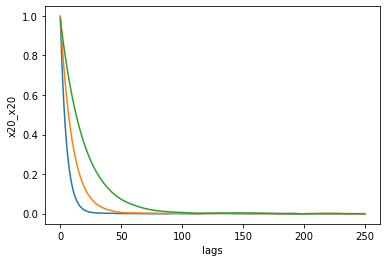

In [12]:
xx.mean(['draw','windows']).plot()
xx10.mean(['draw','windows']).plot()
xx20.mean(['draw','windows']).plot()

### Visualization : 
We plot the same figure that the first one of this notebook for each decorraltion timescale.\
We first do it for non normalized autocorrelation.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


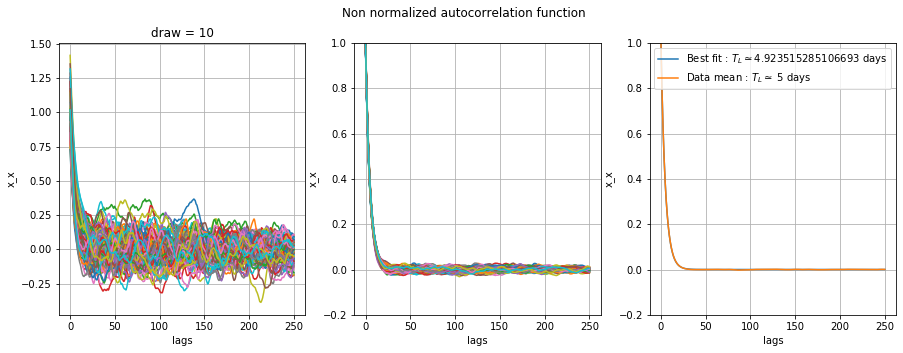

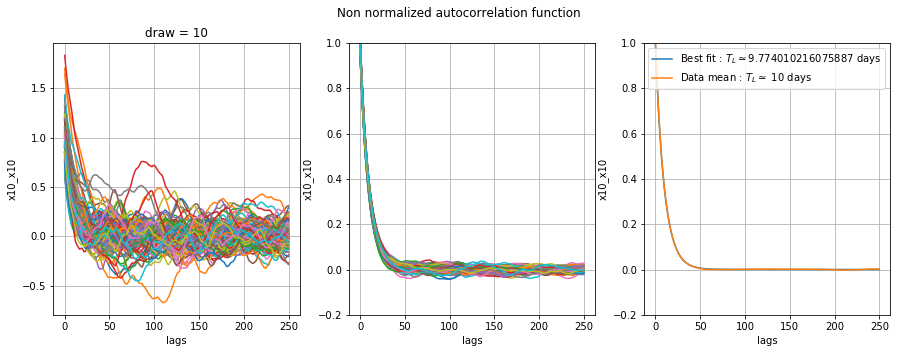

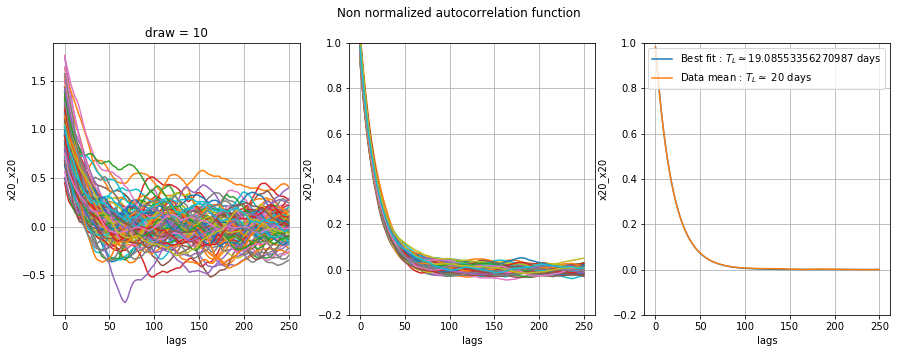

In [8]:
for X,TL in zip([xx,xx10,xx20],Tl):#,xx10,xx20]:
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    _ = X.isel(draw=10).plot.line(ax=axes[0],x='lags',label='')
    axes[0].legend().set_visible(False);axes[0].grid()
    _ = X.mean('draw').plot.line(ax=axes[1],x='lags',label='')
    axes[1].legend().set_visible(False);axes[1].set_ylim(-0.2,1);axes[1].grid()
    pa,co = scipy.optimize.curve_fit(C_exp,X.lags,X.mean(['draw','windows']))
    C_exp(X.lags,*[p for p in pa]).plot(ax=axes[2],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    X.mean(['draw','windows']).plot(ax=axes[2],label='Data mean : $T_L\simeq$ %s days'%TL)
    axes[2].legend();axes[2].set_ylim(-0.2,1);axes[2].grid()
    fig.suptitle('Non normalized autocorrelation function')

### Comments : 
The distribution for all segments for one draw, seems to become wider with increasing $T_L$. same remark for the mean over all draw for each segment. Finaly the fit gets better with decreasing $T_L$ with relative error of $\sim$5% for 20days, $\sim$2%  for 10 days and $\sim$2% for 5 days.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


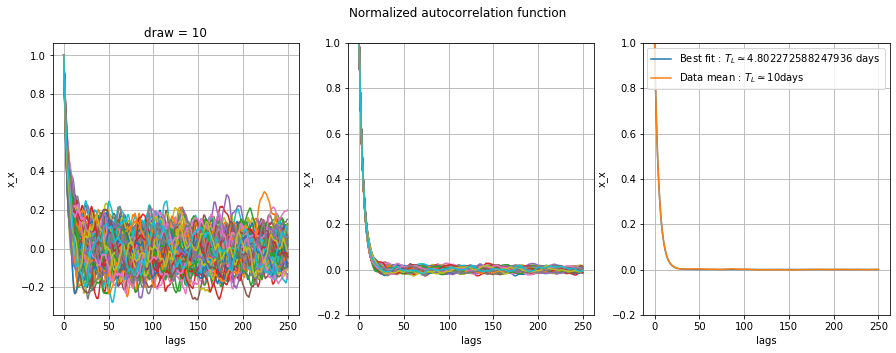

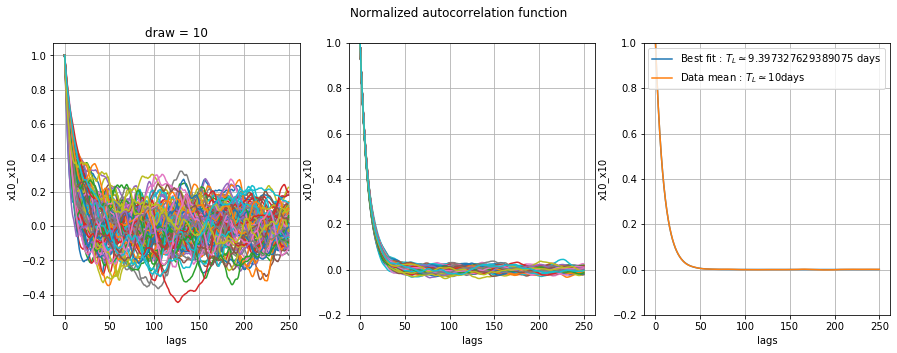

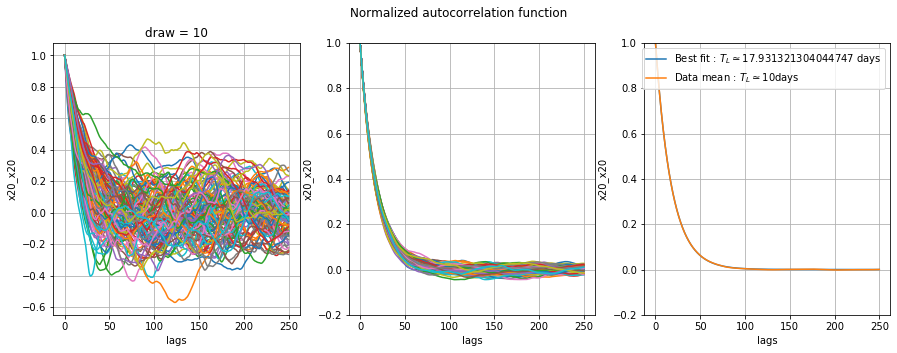

In [9]:
#Normalized autocorrelation
for X in [(xx/xx.sel(lags=0)),(xx10/xx10.sel(lags=0)),(xx20/xx20.sel(lags=0))]:#,(xx10/xx10.sel(lags=0)),(xx20/xx20.sel(lags=0))]:
    fig, axes = plt.subplots(1,3,figsize=(15,5))

    _ = X.isel(draw=10).plot.line(ax=axes[0],x='lags',label='')
    axes[0].legend().set_visible(False);axes[0].grid()
    _ = X.mean('draw').plot.line(ax=axes[1],x='lags',label='')
    axes[1].legend().set_visible(False);axes[1].set_ylim(-0.2,1);axes[1].grid()
    pa,co = scipy.optimize.curve_fit(C_exp,X.lags,X.mean(['draw','windows']))
    C_exp(X.lags,*[p for p in pa]).plot(ax=axes[2],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    X.mean(['draw','windows']).plot(ax=axes[2],label='Data mean : $T_L\simeq$10days')
    axes[2].legend();axes[2].set_ylim(-0.2,1);axes[2].grid()
    fig.suptitle('Normalized autocorrelation function')

#### Comments :
Same remarks than for the non normalized case but with a difference btw 5 days and 10days and largest relative errors : $\sim$10% for 20 days, $\sim$6% for 10 days and $\sim$4% for 5days.

While the accuracy of the fit result increase with decreasing timescale, we note that in the non normalized case we find almost no difference for this accuracy between 5days and 10 days, meaning that in this case, until some point (btw 10 and 20 days) we can find almost similar estimates (the one for 20days being already accurate).

### Variance from one segment to another for one draw : 
We want to see how the autocorrelation varies from segment to another depending on the decorrlation timescale. For this we plot for one draw the mean over all segments as well as the 10th and 90th percentiles. We show the results for  both normalized (first line) and non normalized cases (second line).

In [10]:
def plot_correlation(_xx,ax,norm=False):
    if norm:
        _xx = _xx/_xx.sel(lags=0)
    mean = _xx.mean('windows')
    quantiles = [0.1, .9]
    qt = _xx.chunk(-1).quantile(q=quantiles, dim='windows').persist()

    mean.plot.line(ax=ax,x='lags', lw=4, add_legend=False, 
                   label='mean')
    qt.plot.line(ax=ax,x='lags', lw=4, color='.5')
    ax.grid();ax.set_ylim(-0.3,1.25)
    ax.legend()

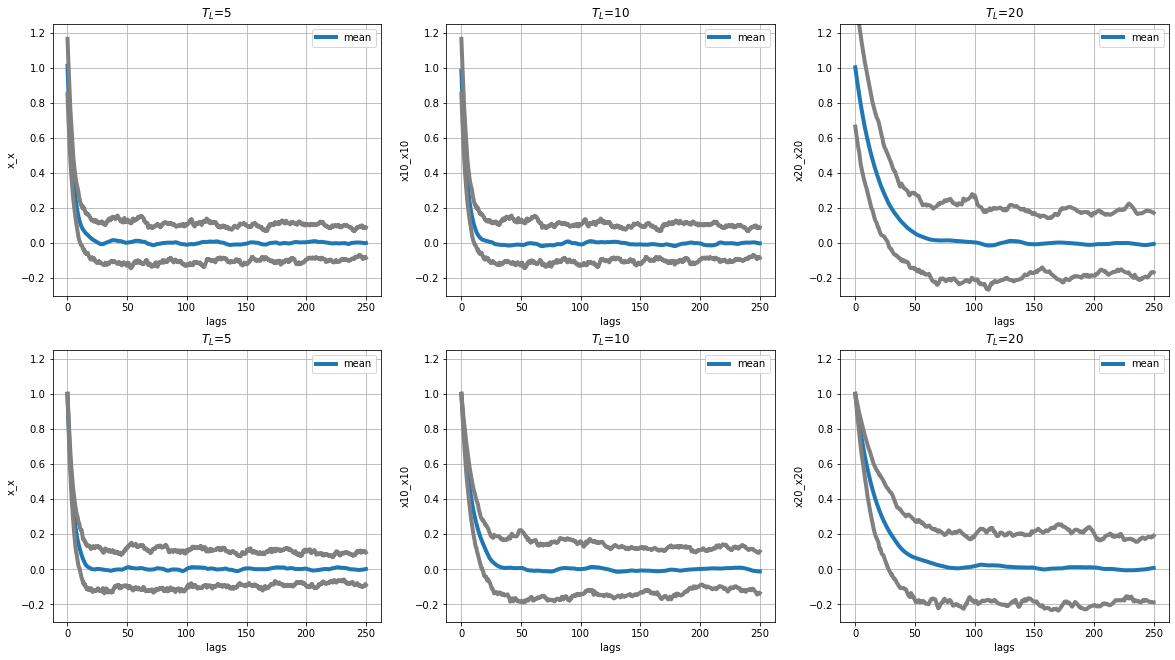

In [11]:
fig,axes = plt.subplots(2,3,figsize=(20,11))
for X,title,ax in zip([xx,xx10,xx20],['5','10','20'],axes[0,:]):
    plot_correlation(X.isel(draw=10),ax)
    ax.set_title(r'$T_L$='+title)
for X,title,ax in zip([xx,xx10,xx20],['5','10','20'],axes[1,:]):
    plot_correlation(X.isel(draw=10),ax,norm=True)
    ax.set_title(r'$T_L$='+title)

### Comments : 
1st line, no normalization : The larger the decorrelation timescale is, the wider distribution is from a window to another (as seen in previous figures). The difference between $T_L$=5 days and $T_L$=10 days does not seem to be large while it is very clear for $T_L$=20days.\
2nd line, normalization : Same than previously but the difference btw 5days and 10 days is more marked (-0.1 to 0.1 for 5d vs -0.2 to 0.2 for 10d).

#### Varying the number of segments : 
We show the same than previouly but for different number of segments.

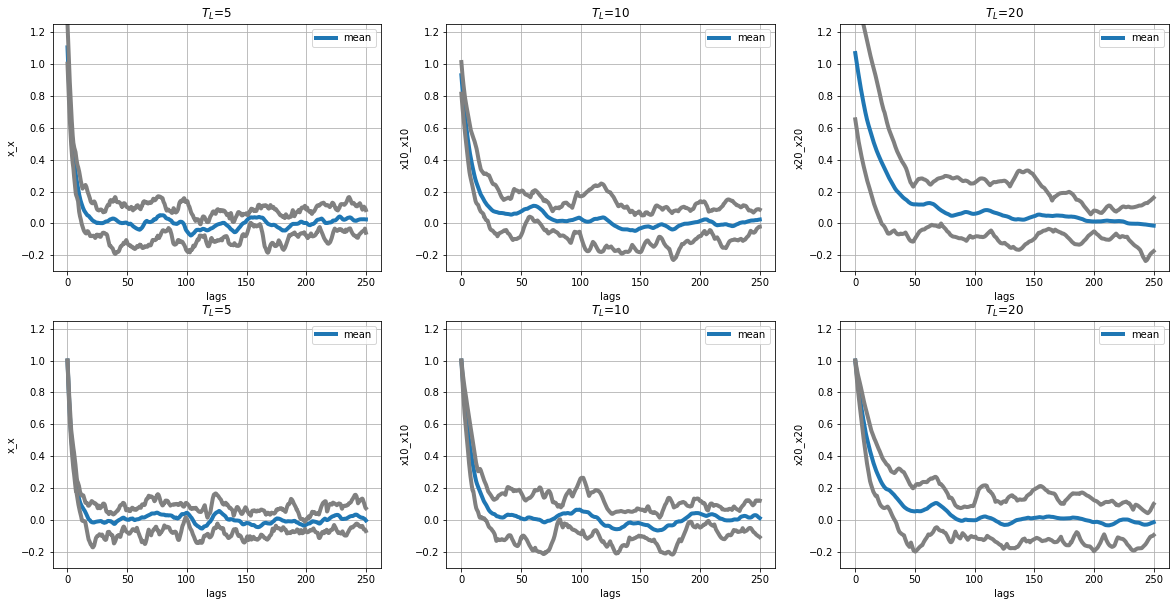

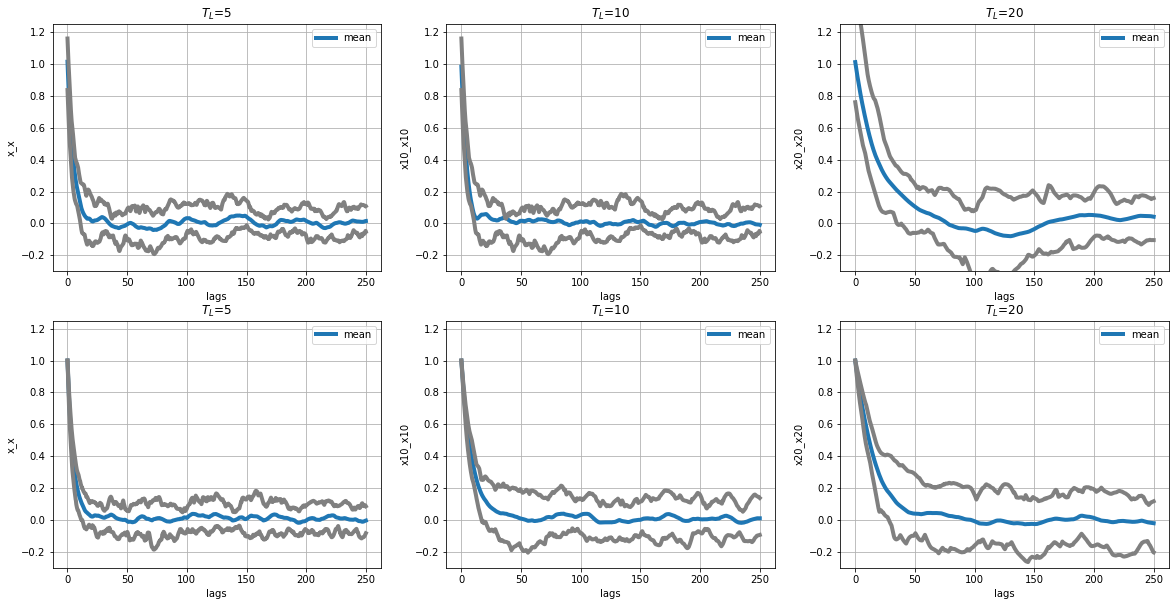

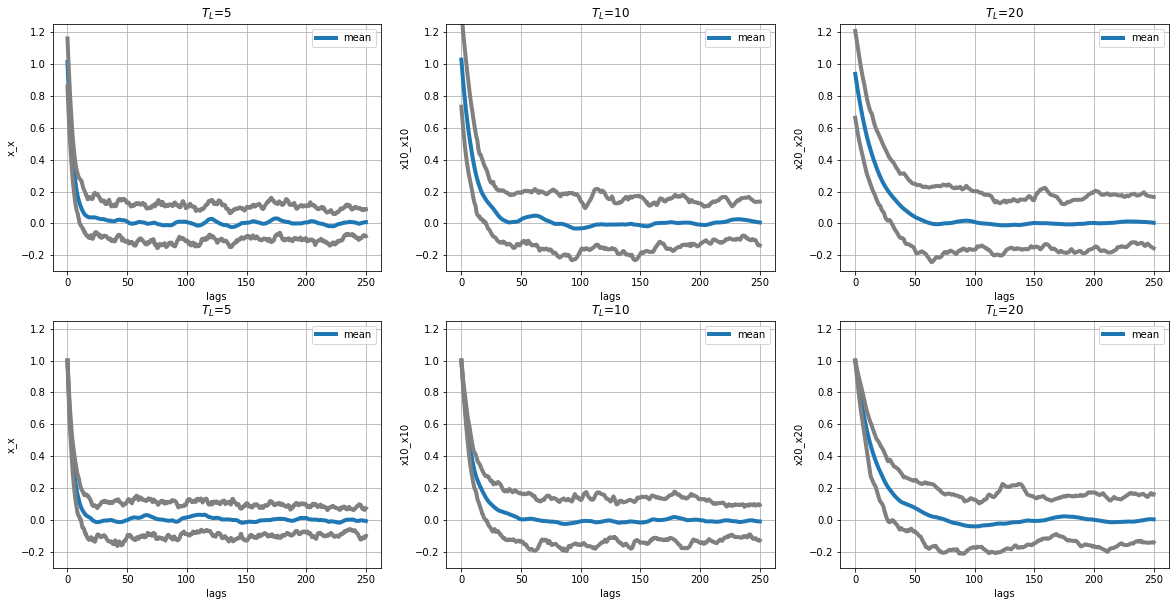

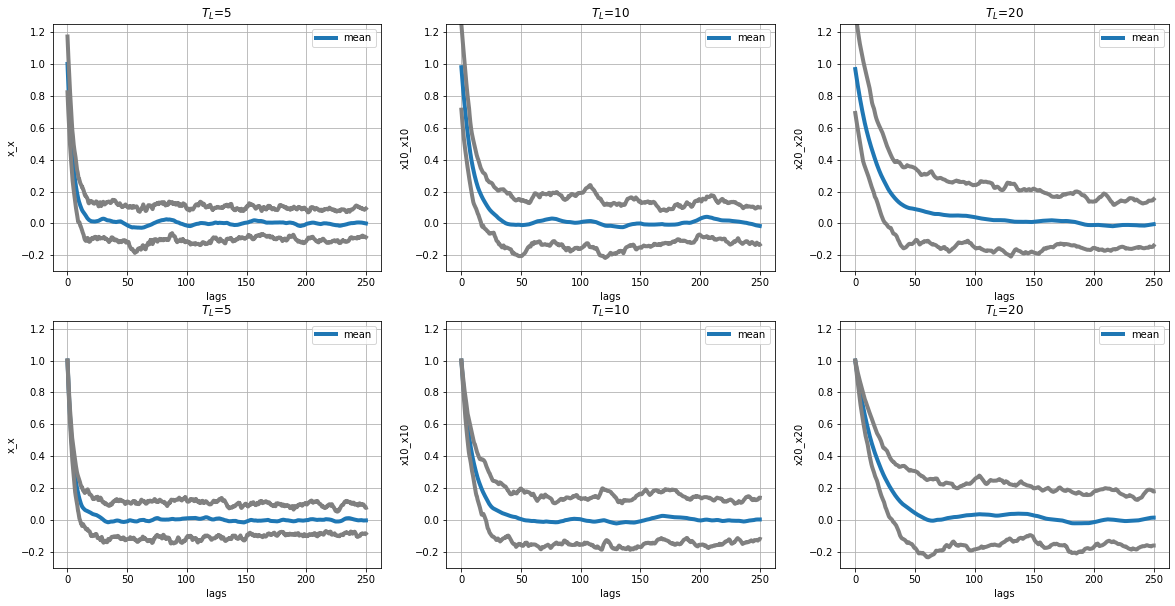

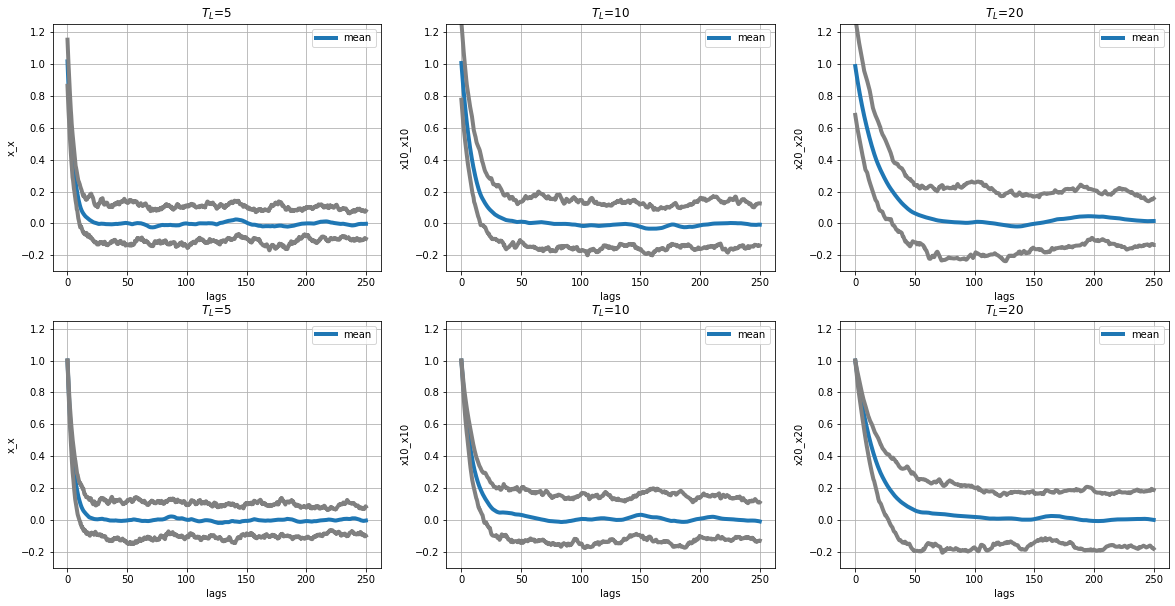

In [12]:
Nw = [10,20,30,40,50]
for nw in Nw : 
    fig,axes = plt.subplots(2,3,figsize=(20,10))
    for X,title,ax in zip([xx,xx10,xx20],['5','10','20'],axes[0,:]):
        plot_correlation(X.isel(draw=10).isel(windows=slice(0,nw)),ax)
        ax.set_title(r'$T_L$='+title)
    for X,title,ax in zip([xx,xx10,xx20],['5','10','20'],axes[1,:]):
        plot_correlation(X.isel(draw=10).isel(windows=slice(0,nw)),ax,norm=True)
        ax.set_title(r'$T_L$='+title)

### Comments : 
We observe for each number of segments, the same increase with the decorrelation timescale than previously.\
The variation in the number of segments does not seem to play a role in the extreme values. We observe however a smoothing of the function when the number segment increases.

### Variations of the estimation of the decorrelation timescale depending on the time window sizes and number of segments for three decorrelation timescales.

### 1 : $T_L$=5days

In [8]:
Tw = np.hstack([np.arange(20,120,20),np.arange(120,350,50)])
Nw = np.arange(1,50,5)#[2,5,10,20,30]
out = xr.combine_nested([[param_fit(x,C_exp,T,nt,Tl[0],100)for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out['Nw'] = Nw
out['Tw'] = Tw

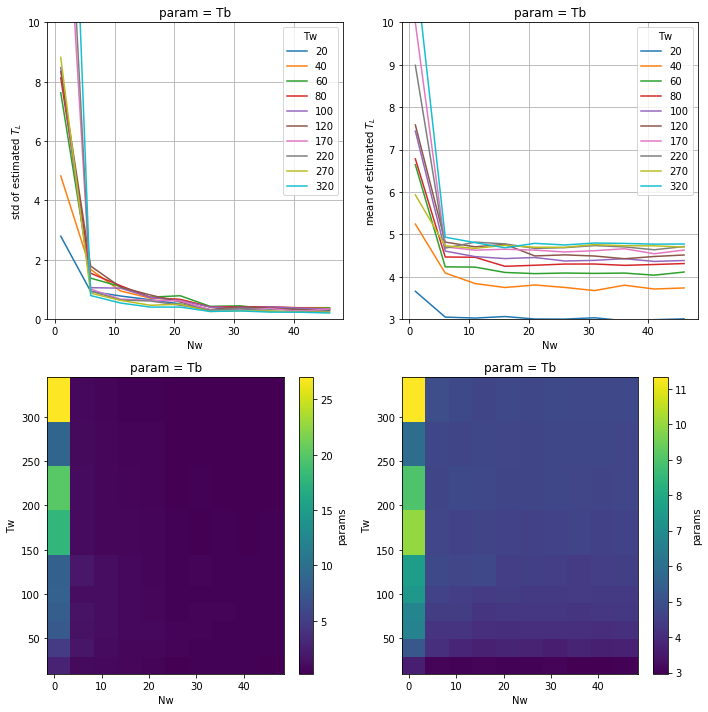

In [13]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(3,10)
out['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()
fig.tight_layout()

#### Comments : 
Very small number segments gives very high std and large bias. We note that the results seems to converge for a umber of segments $N_w\geq6$. For this condition, for all time window sizes, the std is close to one. The estimation of $T_L$ gets closer to the true value 5 with ncreasing Tw. We find the estimation within a 1day interval of the true value for Tw$\geq$60d, we observe however a negative bias for all Tw.

### 2 : $T_L$=10days

In [10]:
out10 = xr.combine_nested([[param_fit(x10,C_exp,T,nt,Tl[1],100)for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out10['Nw'] = Nw
out10['Tw'] = Tw

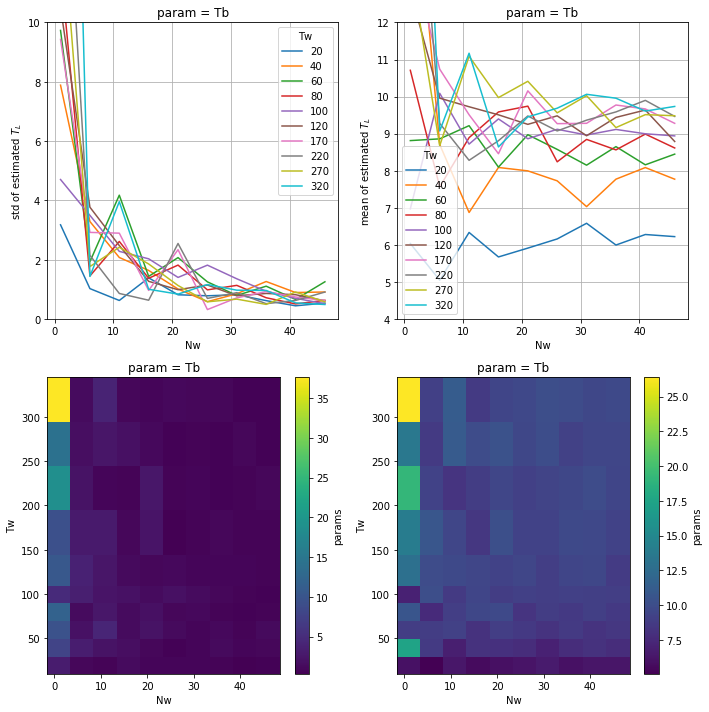

In [11]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out10['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out10['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
out10['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out10['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()
fig.tight_layout()

### Comments : 
Std tends towards 1 after Nw=30\
LArge differences from a Nw to another in the mean estimate. Those values are howerver superior to 9days for Tw$\geq$100days

### 3 : $T_L$=20days

In [9]:
out20 = xr.combine_nested([[param_fit(x20,C_exp,T,nt,Tl[2],100)for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out20['Nw'] = Nw
out20['Tw'] = Tw

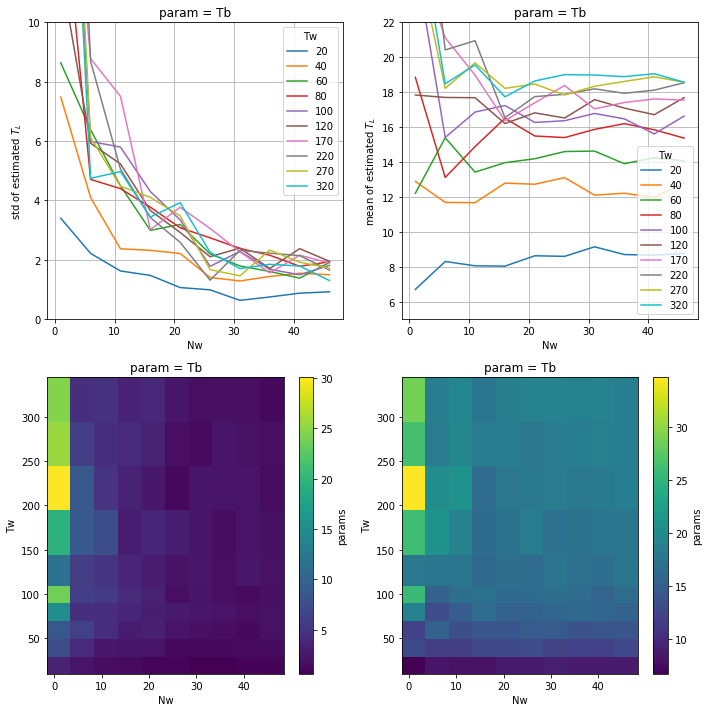

In [10]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out20['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out20['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(5,22)
out20['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out20['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()
fig.tight_layout()

### Comments : 
Std tends towards 2 for large number of segments.\
Same remarks than for $T_L$=10days concerning the mean estimate. The estimates are superior to 18d for $T_w\geq$22

#### Synthesis :

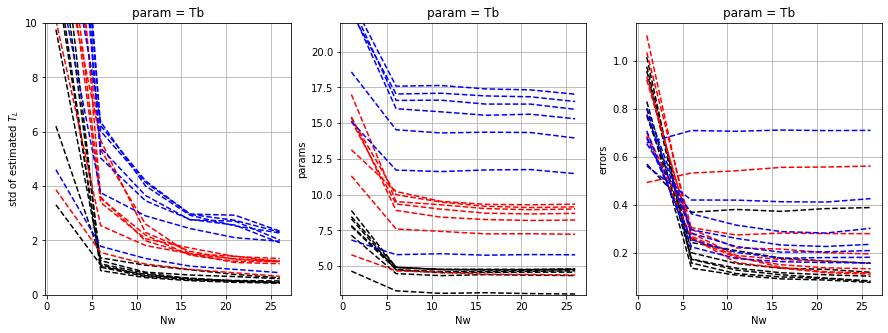

In [21]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
for T,o,c in zip(Tl,[out,out10,out20],['k--','r--','b--']):
    o['params'].sel(param='Tb').std('draws').plot.line(c,ax=axes[0],x='Nw',add_legend=False);
    axes[0].set_ylabel(r'std of estimated $T_L$');axes[1].set_ylabel(r'mean of estimated $T_L$')
    axes[2].set_ylabel(r'mean of relative error')
    o['params'].sel(param='Tb').mean('draws').plot.line(c,ax=axes[1],x='Nw',add_legend=False)
    o['errors'].sel(param='Tb').mean('draws').plot.line(c,ax=axes[2],x='Nw',add_legend=False)
    axes[0].set_ylim(0,10);axes[1].set_ylim(3,22);axes[0].grid();axes[1].grid();axes[2].grid()

#### Comments : 
Black lines : $T_L$ = 5days\
Red lines : $T_L$ = 10days\
Blue lines : $T_L$ = 20days\
$T_L$=5:\
The results are clearly better for $T_l$=5, which was expected. The std is close to one for time window sizes and Nw$\geq$6. For $T_w$>20 and $N_w\geq$6, the sestimated decorrelation timescale is close to the true value with e mean relative error inferior to 0.2.\
$T_L$=10:\
Same remarks than the ones done previously : good results for $T_w\geq$170days and $N_w\geq6$\
$T_L$=20:\
The results are overall not very good, with estimated values never reaching over 18 days

### Non normalized case : 
Same analysis but for non normailzed cases

### 1 : $T_L$=5days

In [7]:
Tw = np.hstack([np.arange(20,120,20),np.arange(120,350,50)])
Nw = np.arange(1,50,5)
out_nonorm = xr.combine_nested([[param_fit(x,C_exp,T,nt,Tl[0],100,X='')for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out_nonorm['Nw']=Nw
out_nonorm['Tw']=Tw

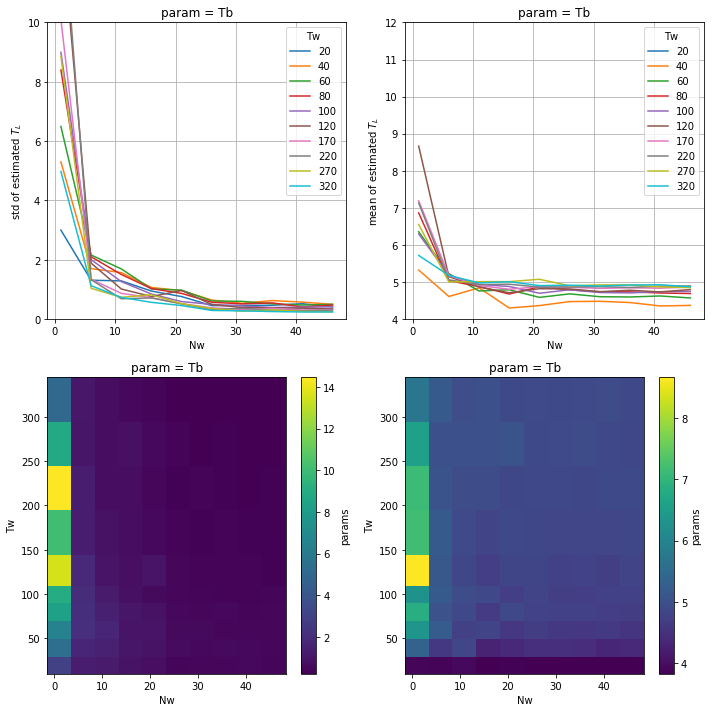

In [7]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out_nonorm['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out_nonorm['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
out_nonorm['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out_nonorm['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()
fig.tight_layout()

### Comments : 
Same observations than in the normalized case for the std. The estimation of $T_L$ is better, with anegative bias smaller and all estimations within the 1day interval.

(1.3, 1.7)

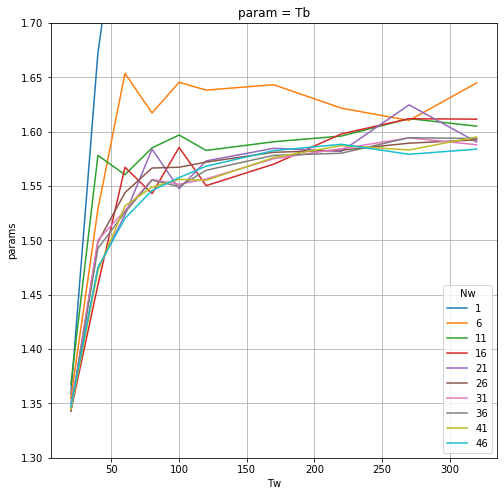

In [17]:
# Loi Tw
fig,ax = plt.subplots(figsize=(8,8))
(np.log(out_nonorm.sel(param='Tb').params.mean('draws'))).plot(ax=ax, x='Tw',hue='Nw')
ax.grid();ax.set_ylim(1.3,1.7)


### 2 : $T_L$=10days

In [ ]:
out10_nonorm = xr.combine_nested([[param_fit(x10,C_exp,T,nt,Tl[1],100,X='')for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out10_nonorm['Nw'] = Nw
out10_nonorm['Tw'] = Tw

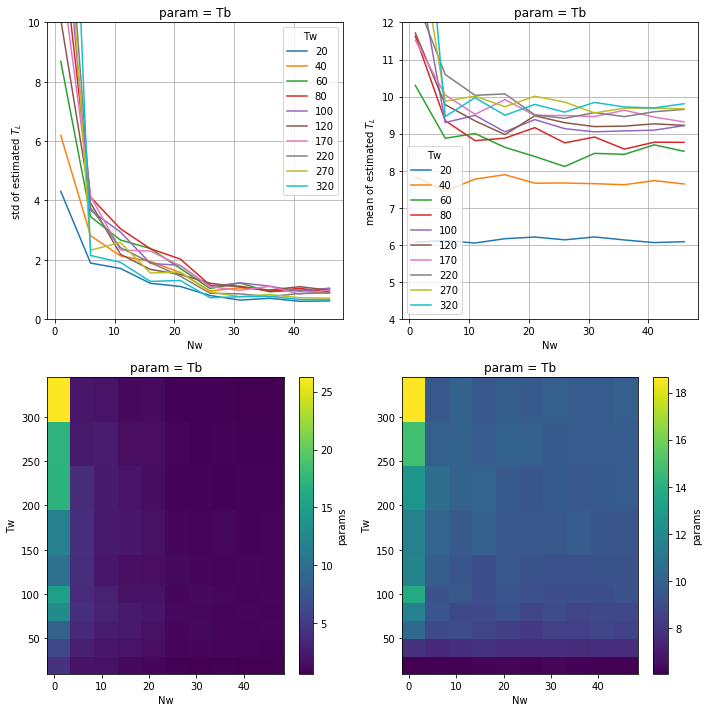

In [8]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out10_nonorm['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out10_nonorm['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
out10_nonorm['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out10_nonorm['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()
fig.tight_layout()

### Comments : 
Higher std than in the previous case but still close to 1. \
Negative bias, estimates within 1d interval for $T_w\geq$100days

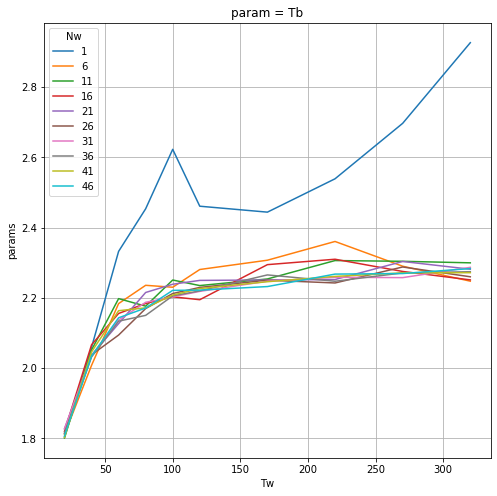

In [11]:
# Loi Tw
fig,ax = plt.subplots(figsize=(8,8))
(np.log(out10_nonorm.sel(param='Tb').params.mean('draws'))).plot(ax=ax, x='Tw',hue='Nw')
ax.grid()#;ax.set_ylim(1.3,1.7)

### 3 : $T_L$=20days

In [ ]:
out20_nonorm = xr.combine_nested([[param_fit(x20,C_exp,T,nt,Tl[2],100,X='')for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out20_nonorm['Nw'] = Nw
out20_nonorm['Tw'] = Tw

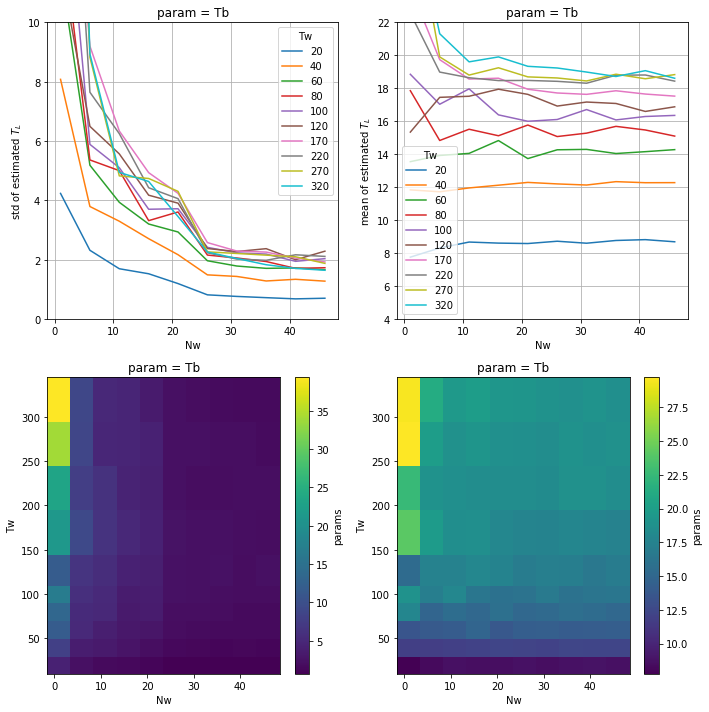

In [8]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out20_nonorm['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out20_nonorm['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,22)
out20_nonorm['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out20_nonorm['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()
fig.tight_layout()

### Comments : 
Std around 2 for most of the time window sizes\
Negative bias for the estimate but values closer to the true one.

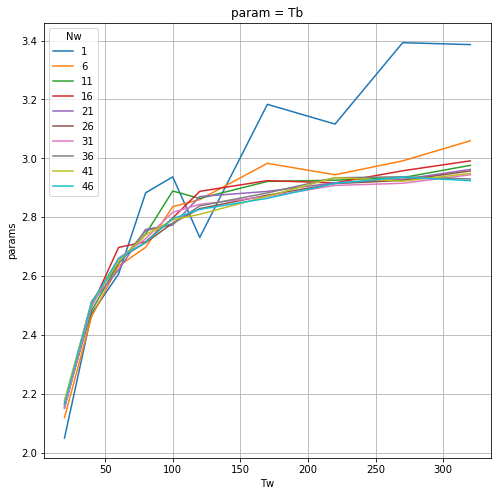

In [9]:
# Loi Tw
fig,ax = plt.subplots(figsize=(8,8))
(np.log(out20_nonorm.sel(param='Tb').params.mean('draws'))).plot(ax=ax, x='Tw',hue='Nw')
ax.grid()#;ax.set_ylim(1.3,1.7)

#### Comments normalized/non normalized : 
Better estimation of the decorrelation timescale for all $T_L$ without noralization.\
Less impact of Nw without normalization (for $N_w\geq$6).\
It seems to more accurate to continue our study with non normalized models.

### General comments on the results : 
#### Conditions of the fit (detrend, norm,...) : 
Detrending : The detrending seems to bring large bias in the estimation of $T_L$.\
Fit over raw vs averaged data : The fit over each draw and window gives biased results.\
Normalization : The non normalized autocorrelation functions present better results with a small bias for time windows sizes superior to 70days.
#### Impact time window size/number :
Nw : At least $\sim$ 5segments seems to be necessary (to be confirmed by studying cases of $N_w\in$[1;6]\
Tw : The estimates get close (within $\sim$10% relative error) to the true value when the time window size is around 10 times the de correlation timescale.

### Oscillatory process (internal tides):
$x = a(t) cos(\omega t)$\
$R_{xx} = \frac{R_a}{2} cos(\omega \tau)$ where $R_a=e^{-\tau/T_L}$

In [3]:
def C_per(t,Tl):
    return np.exp(-t/Tl)/2*np.cos(2*np.pi*2*t)

In [4]:
DT = 100
nT = 10
n = 100
Tl = 10
x = ts.exp_autocorr((DT, 1./24), np.full((nT,),Tl), 1, draws=n).rename('x').compute()
X = (x*np.cos(2*np.pi*2*x.time)).rename('X').compute()
X

<xarray.DataArray 'X' (tau: 10, draw: 100, time: 2400)>
array([[[-3.14878204e-02,  1.99557863e-02,  7.86272327e-02, ...,
          2.19901777e-13, -7.26464263e-01, -1.19602336e+00],
        [-8.48962066e-02, -2.12340373e-02,  4.05014331e-02, ...,
         -9.59729263e-14,  2.84759781e-01,  5.13435227e-01],
        [-1.14527885e-01, -5.33768983e-02,  1.45614165e-02, ...,
          1.42553706e-13, -3.37646483e-01, -5.20606285e-01],
        ...,
        [-8.47801898e-02, -9.89794540e-02, -1.50112756e-01, ...,
         -1.78702933e-13,  5.70539611e-01,  9.95513738e-01],
        [-1.06677475e-01, -5.00041838e-02, -3.96231951e-02, ...,
          2.35348866e-14, -6.06037419e-02, -3.00797911e-02],
        [-9.91387472e-02, -6.31183044e-02, -9.14713283e-03, ...,
          9.17459752e-15,  3.17137106e-03,  3.57072012e-02]],

       [[-7.93866635e-02, -3.09095850e-01, -1.31914510e-01, ...,
         -2.72916188e-13,  9.16169131e-01,  1.57868550e+00],
        [-2.23879204e-02, -8.63868772e-03,  7.16701217e-02, ...,
         -1.24478275e-13,  4.10941752e-01,  7.33343764e-01],
        [ 7.14140957e-02,  8.85266142e-02,  1.82847772e-02, ...,
         -2.47807239e-13,  7.13403903e-01,  1.12815162e+00],
        ...,
        [-1.26136948e-01, -9.69485210e-02,  5.51515780e-03, ...,
         -6.44723325e-14,  1.88910585e-01,  2.84429108e-01],
        [-1.28709659e-01, -7.19175086e-02, -7.72733633e-02, ...,
          9.28730761e-14, -3.00179731e-01, -5.62470610e-01],
        [-4.27354687e-02, -1.30426889e-02,  2.41079108e-02, ...,
         -1.08831908e-13,  2.47407354e-01,  5.26372258e-01]],

       [[-1.32639816e-01, -8.99555273e-02, -2.19027364e-02, ...,
         -1.06859680e-13,  3.09956594e-01,  5.50276693e-01],
        [-4.24977351e-02, -2.81398763e-02, -8.12798048e-03, ...,
         -2.21242046e-14,  9.77437175e-02,  1.27354485e-01],
        [ 1.57675661e-01,  1.75334027e-01,  1.78356713e-03, ...,
          1.87043092e-13, -6.36926988e-01, -1.06769536e+00],
        ...,
        [ 1.22513078e-01,  2.72673446e-02,  8.37337022e-02, ...,
          1.88345811e-13, -6.07518081e-01, -9.59789036e-01],
        [ 4.68912746e-02,  4.34763829e-02, -8.62541052e-02, ...,
          2.29011204e-13, -8.05938236e-01, -1.25228579e+00],
        [ 7.67879508e-02, -5.08463394e-02, -9.39945357e-02, ...,
          4.19310221e-14, -1.26402627e-01, -2.89739551e-01]],

       ...,

       [[ 4.80963936e-02,  9.45807402e-02,  1.45269111e-01, ...,
         -2.13242712e-14,  1.42450253e-01,  2.09216562e-01],
        [ 7.66453520e-02,  1.14508820e-01,  6.75992724e-02, ...,
          1.51076654e-13, -4.92779735e-01, -8.59319217e-01],
        [-1.10248815e-01, -1.09713228e-01, -1.74938936e-02, ...,
         -1.74832388e-14,  3.64587164e-02,  1.47088262e-01],
        ...,
        [-3.36958583e-02, -1.74106112e-02,  5.33833492e-02, ...,
          2.98868561e-15,  3.99259632e-03,  1.52964810e-02],
        [ 2.80159647e-01,  1.86051851e-01,  1.33596837e-01, ...,
          4.20339861e-15, -5.52249181e-03,  1.32583271e-01],
        [ 8.36730003e-02,  6.94793638e-02,  6.94990099e-02, ...,
          2.31181670e-13, -7.33159958e-01, -1.29740315e+00]],

       [[ 1.20590222e-01, -2.70562507e-02, -2.47581356e-02, ...,
          1.05657910e-13, -3.34527811e-01, -6.19960731e-01],
        [ 1.73469280e-01,  8.83537599e-02,  7.62286331e-02, ...,
         -1.56069651e-13,  5.08702872e-01,  9.48488997e-01],
        [-1.95343817e-02, -7.91415904e-02,  4.33426433e-02, ...,
         -9.96556869e-14,  3.36688212e-01,  6.17079897e-01],
        ...,
        [-1.23561971e-01, -2.61583678e-01, -1.89156634e-01, ...,
          1.04042021e-13, -3.41641825e-01, -5.19672678e-01],
        [ 4.54080313e-02, -9.70209289e-03, -1.10971018e-02, ...,
         -5.37776936e-14,  1.70995059e-01,  3.46464526e-01],
        [ 4.46811968e-02,  5.31474436e-02,  1.08739405e-02, ...,
         -3.12125856e-13,  1.04270183e+00,  1.69673309e+00]],

       [[ 5.37893448e-02,  2.19337980e-01,  1.76638767e-01, ...,
          2

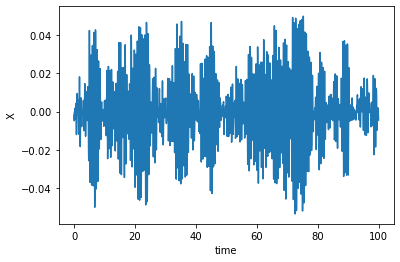

In [5]:
X.mean(['draw','tau']).plot()

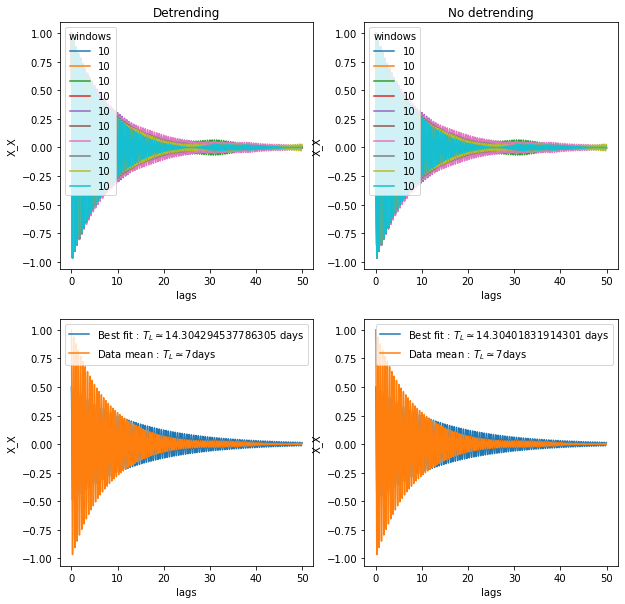

In [35]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for b,title,i in zip([True, False],['Detrending','No detrending'],range(2)):
    xx = ts.correlate(X,X,detrend=b).persist()
    _ = (xx/xx.sel(lags=0)).mean('draw').plot.line(ax=axes[0,i],x='lags')
    axes[0,i].set_title(title)
    pa,co = scipy.optimize.curve_fit(C_per,xx.lags,(xx/xx.sel(lags=0)).mean(['draw','windows']))
    C_per(xx.lags,*[p for p in pa]).plot(ax=axes[1,i],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    (xx/xx.sel(lags=0)).mean(['draw','windows']).plot(ax=axes[1,i],label='Data mean : $T_L\simeq$7days')
    axes[1,i].legend()

#### Comments : 
Interestingly we pbserve in some "segments" a node. It would mean that the node we observe in our data has no physical explaination but is an artifact of the correlation function we applied ??

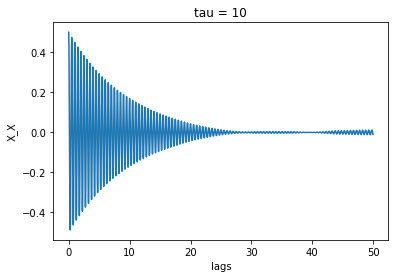

In [15]:
(xx).isel(tau=0).mean('draw').plot()

In [9]:
xx_tst = ts.correlate(x,x,detrend=False).compute()

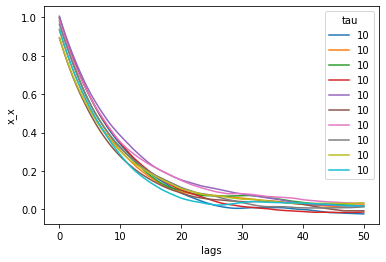

In [14]:
xx_tst.mean('draw').plot.line(x='lags')

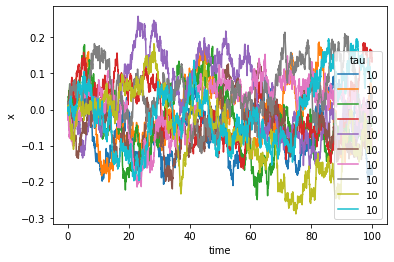

In [12]:
x.mean('draw').plot.line(x='time')

In [20]:
X = X.rename({'tau':'windows'})

In [22]:
def param_fit(x,myfunc,DT,nT,Tl,n,X = 'normalized',detrend=False):
    """Generate n samples using ts.exp_autocorr 
    and find the best fit for each sample and the relative error to the true value Tl 
    """
    sig = signature(myfunc)
    xx = ts.correlate(x.sel(time=slice(0,DT)).isel(windows=slice(0,nT),draw=slice(0,n)),
                      x.sel(time=slice(0,DT)).isel(windows=slice(0,nT),draw=slice(0,n)),detrend=detrend).compute()
    if X=='normalized':
        xx = xx/xx.sel(lags=0) 
    else :
        pass
    pa,err = np.full((xx.draw.size,len(sig.parameters)-1),np.nan),np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
    true_val=[Tl]
    for i in range(xx.draw.size):
        pa[i,:],co = scipy.optimize.curve_fit(myfunc,xx.lags,xx.isel(draw=i).mean(['windows']))
        err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = xr.Dataset({'params':(['draws','param'],pa),
                      'errors':(['draws','param'],err)},
                     coords={"draws":np.arange(0,n,1),'param':[V for V in sig.parameters.keys()][1:]})
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [23]:
out = param_fit(X,C_per,DT,nT,Tl,100)

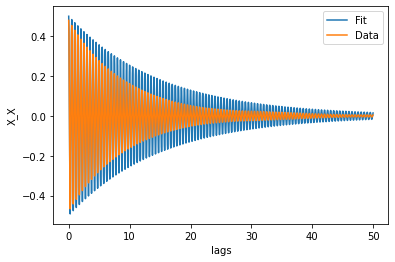

In [37]:
C_per(xx.lags,out.params.sel(param='Tl').mean()).plot(label='Fit')
xx.mean(['draw','windows']).plot(label='Data')
plt.legend()

In [12]:
xx = ts.correlate(X,X,detrend=False).persist()
pa,err = np.full((xx.draw.size),np.nan),np.full(xx.draw.size,np.nan)
for i in range(xx.draw.size):
    pa[i],co = scipy.optimize.curve_fit(C_per,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['tau']))
    err[i] = np.abs(pa[i]-Tl)/Tl



Averaged over all draws and windows of the estimated $T_L$ : 9.485842932378283
Std of the estimated $T_L$ : 2.878946490237734
Mean relative error : 41.976844310389865 percent


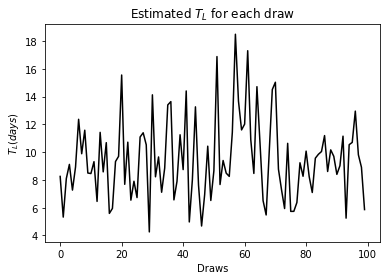

In [13]:
plt.plot(xx.draw,pa,'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa.mean())
print(r'Std of the estimated $T_L$ : %s' %pa.std())
print('Mean relative error : %s percent'% (err.mean()*1e2))

#### Comments : 
The decorrelation timescale is overestimated in the case of a exponentially decaying oscillation. This might be due to the decrease of the amplitude of oscillations leading a least squares that are more easily minimized for larger values of $\tau$. This could be corrected by applying uncertainties increasing with $\tau$ and/or taking smaller time windows.

In [14]:
xx = ts.correlate(X.sel(time=slice(0,20)),X.sel(time=slice(0,20)),detrend=False).persist()
pa,err = np.full((xx.draw.size),np.nan),np.full(xx.draw.size,np.nan)
for i in range(xx.draw.size):
    pa[i],co = scipy.optimize.curve_fit(C_per,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['tau']))
    err[i] = np.abs(pa[i]-Tl)/Tl

Averaged over all draws and windows of the estimated $T_L$ : 7.724407073932331
Std of the estimated $T_L$ : 2.7793049333475803
Mean relative error : 31.332417355759333 percent


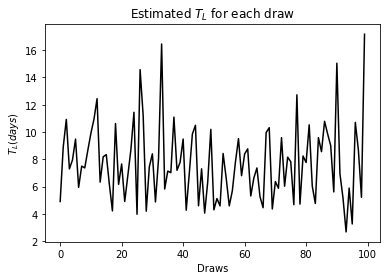

In [15]:
plt.plot(xx.draw,pa,'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa.mean())
print(r'Std of the estimated $T_L$ : %s' %pa.std())
print('Mean relative error : %s percent'% (err.mean()*1e2))

### Comments : 
We obtain a better estimation of the decorrelation timescale : $T_L\simeq 7.7$ vs $T_L\simeq9.5$ 

In [12]:
cluster.close()